In [97]:
# Cell 1: Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import pywt

In [98]:
# Cell 2: Signal extraction function
def extract_ppg_signal(video_path, roi_percentage=0.6):
    """
    Extract PPG signal with ROI selection, exposure stability checks, and quality metrics
    
    Parameters:
    video_path (str): Path to the video file
    roi_percentage (float): Percentage of center frame to use as ROI (0-1)
    
    Returns:
    tuple: (ppg_signal, frame_rate, quality_metric)
    """
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate ROI coordinates (center region of the frame)
    roi_size = int(min(frame_width, frame_height) * roi_percentage)
    roi_x = (frame_width - roi_size) // 2
    roi_y = (frame_height - roi_size) // 2
    
    red_channel_values = []
    frame_brightness = []
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Extract only the ROI
        roi = frame[roi_y:roi_y+roi_size, roi_x:roi_x+roi_size]
        
        # Extract the red channel (assuming OpenCV loads as BGR)
        red_channel = roi[:, :, 2]
        
        # Calculate mean and standard deviation
        avg_intensity = np.mean(red_channel)
        std_intensity = np.std(red_channel)
        
        # Store values
        red_channel_values.append(avg_intensity)
        frame_brightness.append(std_intensity)
        frame_count += 1
    
    cap.release()
    
    # Convert to NumPy arrays
    ppg_signal = np.array(red_channel_values)
    brightness_variation = np.array(frame_brightness)
    
    # Calculate quality metric (lower is better)
    temporal_variation = np.std(np.diff(ppg_signal)) / np.mean(ppg_signal)
    spatial_variation = np.mean(brightness_variation) / np.mean(ppg_signal)
    quality_metric = temporal_variation + spatial_variation
    
    print(f"Extracted {frame_count} frames at {frame_rate:.2f} FPS")
    print(f"Signal quality metric: {quality_metric:.4f} (lower is better)")
    
    return ppg_signal, frame_rate, quality_metric

In [99]:
# Cell 3: Signal preprocessing functions
def bandpass_filter(signal, lowcut=0.5, highcut=4.0, fs=30, order=4):
    """
    Apply bandpass filter with optimal parameters for PPG
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='sym4', level=2, threshold_multiplier=0.5):
    """
    Enhanced wavelet denoising with adaptive thresholding
    """
    # Decompose signal
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Apply adaptive thresholding to detail coefficients only
    for i in range(1, len(coeffs)):
        # Calculate adaptive threshold based on noise estimation
        sigma = np.median(np.abs(coeffs[i])) / 0.6745
        threshold = sigma * threshold_multiplier * np.sqrt(2 * np.log(len(signal)))
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    
    # Reconstruct signal
    return pywt.waverec(coeffs, wavelet)

def remove_outliers(signal, threshold=2.5):
    """
    Remove outliers from signal using median absolute deviation
    """
    # Calculate median and MAD
    median = np.median(signal)
    mad = np.median(np.abs(signal - median))
    
    # Define thresholds
    upper_threshold = median + threshold * mad
    lower_threshold = median - threshold * mad
    
    # Create a mask for valid samples
    mask = (signal >= lower_threshold) & (signal <= upper_threshold)
    
    # Interpolate outliers
    x = np.arange(len(signal))
    valid_indices = x[mask]
    valid_values = signal[mask]
    
    if len(valid_indices) < 2:  # Need at least 2 points for interpolation
        return signal
        
    interp_func = interp1d(valid_indices, valid_values, kind='linear', 
                          fill_value='extrapolate')
    clean_signal = interp_func(x)
    
    return clean_signal

def smooth_signal(signal, window_size=15):
    """
    Apply moving average for baseline trend estimation
    """
    # Ensure window size is odd
    if window_size % 2 == 0:
        window_size += 1
        
    # If signal is shorter than window, use smaller window
    if len(signal) < window_size:
        window_size = len(signal)
        if window_size % 2 == 0:
            window_size -= 1
            
    if window_size < 3:  # Minimum window size
        return signal
        
    return savitzky_golay(signal, window_size, polyorder=1)

def savitzky_golay(signal, window_length=15, polyorder=3):
    """
    Apply Savitzky-Golay filter for smoothing
    """
    # Ensure window length is odd and greater than polyorder
    if window_length % 2 == 0:
        window_length += 1
    if window_length <= polyorder:
        window_length = polyorder + 2
        
    # If signal is shorter than window, use smaller window
    if len(signal) < window_length:
        window_length = len(signal)
        if window_length % 2 == 0:
            window_length -= 1
        polyorder = min(polyorder, window_length - 2)
        
    if window_length < 3:  # Minimum window size
        return signal
        
    # Create coefficient matrix
    x = np.arange(-window_length//2 + 1, window_length//2 + 1)
    X = np.vander(x, polyorder + 1)
    X = X[:, ::-1]  # Reverse columns
    
    # Calculate filter coefficients
    B = np.linalg.pinv(X.T @ X) @ X.T
    
    # Apply filter
    padded_signal = np.pad(signal, (window_length//2, window_length//2), mode='edge')
    smoothed = np.zeros_like(signal)
    
    for i in range(len(signal)):
        segment = padded_signal[i:i+window_length]
        smoothed[i] = np.dot(B[0], segment)
    
    return smoothed

In [100]:
# Cell 4: Main preprocessing pipeline
def preprocess_ppg_signal(signal, sampling_rate, quality_metric):
    """
    Comprehensive preprocessing pipeline with adaptive parameters based on signal quality
    
    Parameters:
    signal (ndarray): Raw PPG signal
    sampling_rate (float): Signal sampling rate in Hz
    quality_metric (float): Signal quality metric
    
    Returns:
    ndarray: Processed PPG signal
    """
    # 1. Detrend the signal (remove slow baseline drift)
    detrended = signal - smooth_signal(signal, window_size=int(sampling_rate*2))
    
    # 2. Adaptive bandpass filtering based on signal quality
    if quality_metric > 0.1:  # Poor quality signal needs narrower filter
        lowcut, highcut = 0.8, 3.0
    else:  # Better quality signal can use wider filter
        lowcut, highcut = 0.5, 4.0
        
    filtered = bandpass_filter(detrended, lowcut=lowcut, highcut=highcut, fs=sampling_rate)
    
    # 3. Remove outliers (samples that deviate too much from neighbors)
    filtered = remove_outliers(filtered, threshold=2.5)
    
    # 4. Apply wavelet denoising with adaptive parameters
    if quality_metric > 0.1:  # Poor quality needs more aggressive denoising
        level = 3
        threshold_multiplier = 0.3
    else:
        level = 2
        threshold_multiplier = 0.5
        
    denoised = wavelet_denoise(filtered, wavelet='sym4', level=level, 
                               threshold_multiplier=threshold_multiplier)
    
    # 5. Standardize signal amplitude
    normalized = (denoised - np.mean(denoised)) / np.std(denoised)
    
    # 6. Apply Savitzky-Golay filter for final smoothing
    window_length = int(sampling_rate / 2)  # ~0.5 second window
    if window_length % 2 == 0:  # Must be odd
        window_length += 1
    smoothed = savitzky_golay(normalized, window_length=window_length, polyorder=3)
    
    return smoothed

In [101]:
def extract_features(signal, sampling_rate):
    """
    Extract time-domain and frequency-domain features from PPG signal
    
    Parameters:
    signal (ndarray): Processed PPG signal
    sampling_rate (float): Signal sampling rate in Hz
    
    Returns:
    dict: Dictionary of features
    """
    features = {}
    
    # Time domain features
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['range'] = features['max'] - features['min']
    features['rms'] = np.sqrt(np.mean(np.square(signal)))
    
    # Find peaks (systolic peaks in PPG)
    peaks, _ = find_peaks(signal, distance=int(sampling_rate*0.5))
    
    if len(peaks) > 1:
        # Calculate heart rate
        peak_intervals = np.diff(peaks) / sampling_rate  # in seconds
        heart_rates = 60 / peak_intervals  # in bpm
        features['heart_rate'] = np.mean(heart_rates)
        features['heart_rate_std'] = np.std(heart_rates)
        
        # Calculate features based on peaks
        peak_heights = signal[peaks]
        features['peak_height_mean'] = np.mean(peak_heights)
        features['peak_height_std'] = np.std(peak_heights)
        
        # Calculate pulse width (approximation)
        pulse_width = []
        for i in range(len(peaks)-1):
            half_height = (signal[peaks[i]] + np.min(signal[peaks[i]:peaks[i+1]])) / 2
            above_threshold = signal[peaks[i]:peaks[i+1]] > half_height
            width = np.sum(above_threshold) / sampling_rate  # in seconds
            pulse_width.append(width)
            
        if pulse_width:
            features['pulse_width_mean'] = np.mean(pulse_width)
            features['pulse_width_std'] = np.std(pulse_width)
    else:
        # Default values if not enough peaks found
        features['heart_rate'] = 0
        features['heart_rate_std'] = 0
        features['peak_height_mean'] = 0
        features['peak_height_std'] = 0
        features['pulse_width_mean'] = 0
        features['pulse_width_std'] = 0
    
    return features


In [102]:
def segment_for_prediction(signal, target_length=300, overlap=0.5):
    """
    Segment signal into fixed-length windows suitable for ML prediction
    
    Parameters:
    signal (ndarray): Processed PPG signal
    target_length (int): Required segment length for the model
    overlap (float): Overlap between segments (0-1)
    
    Returns:
    list: List of signal segments
    """
    segments = []
    step = int(target_length * (1 - overlap))
    
    # If signal is shorter than target_length
    if len(signal) < target_length:
        # Pad the signal to match the target length
        padded = np.pad(signal, (0, target_length - len(signal)), mode='reflect')
        segments.append(padded)
        return segments
        
    # Create overlapping segments
    for i in range(0, len(signal) - target_length + 1, step):
        segment = signal[i:i+target_length]
        segments.append(segment)
        
    # If no complete segments were created, use the entire signal
    if len(segments) == 0:
        padded = np.pad(signal, (0, target_length - len(signal)), mode='reflect')
        segments.append(padded)
        
    return segments

def prepare_for_prediction(signal, target_length=302):
    """
    Prepare signal for model prediction by ensuring correct shape
    
    Parameters:
    signal (ndarray): Processed PPG signal
    target_length (int): Required length for the model
    
    Returns:
    ndarray: Model-ready signal
    """
    # Ensure correct length
    if len(signal) > target_length:
        # Use the center portion
        start = (len(signal) - target_length) // 2
        signal = signal[start:start+target_length]
    elif len(signal) < target_length:
        # Pad with reflection
        padding = ((target_length - len(signal)) // 2, target_length - len(signal) - (target_length - len(signal)) // 2)
        signal = np.pad(signal, padding, mode='reflect')
    
    # Normalize for model input
    signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-8)
    
    # Reshape for model: expects (batch_size, sequence_length, 1)
    return np.expand_dims(np.expand_dims(signal, axis=0), axis=-1)

In [103]:
# Cell 6: Visualization functions
def plot_processing_steps(raw_signal, processed_signal, sampling_rate, title="PPG Signal Processing"):
    """
    Plot raw and processed signals with diagnostic information
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # Time axis in seconds
    time = np.arange(len(raw_signal)) / sampling_rate
    
    # Plot raw signal
    ax1.plot(time, raw_signal, 'b-')
    ax1.set_title('Raw PPG Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Red Channel Intensity')
    
    # Plot processed signal
    ax2.plot(time[:len(processed_signal)], processed_signal, 'r-')
    ax2.set_title('Processed PPG Signal')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Normalized Amplitude')
    
    # Find peaks in processed signal for heart rate estimation
    peaks, _ = find_peaks(processed_signal, distance=int(sampling_rate*0.5))
    
    # Plot processed signal with peaks
    ax3.plot(time[:len(processed_signal)], processed_signal, 'g-')
    ax3.plot(time[:len(processed_signal)][peaks], processed_signal[peaks], 'ro')
    
    # Calculate and display heart rate
    if len(peaks) > 1:
        intervals = np.diff(peaks) / sampling_rate
        hr = 60 / np.mean(intervals)
        ax3.set_title(f'Peak Detection - Estimated HR: {hr:.1f} BPM')
    else:
        ax3.set_title('Peak Detection - Not enough peaks detected')
    
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92)
    
    return fig


In [104]:
def process_video_for_glucose_prediction(video_path, model=None, calibration_factor=1.0, calibration_offset=0.0):
    """
    Process video and predict glucose level
    
    Parameters:
    video_path (str): Path to the video file
    model: The prediction model
    calibration_factor (float): Multiplication factor for calibration
    calibration_offset (float): Offset value for calibration
    
    Returns:
    dict: Dictionary with prediction results and diagnostic information
    """
    # Extract signal from video
    raw_signal, sampling_rate, quality_metric = extract_ppg_signal(video_path)
    
    # Process the PPG signal
    processed_signal = preprocess_ppg_signal(raw_signal, sampling_rate, quality_metric)
    
    # Plot processing steps
    fig = plot_processing_steps(raw_signal, processed_signal, sampling_rate)
    
    # Extract features
    features = extract_features(processed_signal, sampling_rate)
    
    # Prepare signal for model prediction
    model_input = prepare_for_prediction(processed_signal)
    
    # Make prediction if model is provided
    prediction = None
    if model is not None:
        # This is a placeholder - actual implementation depends on your model
        try:
            prediction = model.predict(model_input)[0][0]
            # Apply calibration
            prediction = prediction * calibration_factor + calibration_offset
        except Exception as e:
            print(f"Prediction error: {e}")
    
    results = {
        'raw_signal': raw_signal,
        'processed_signal': processed_signal,
        'sampling_rate': sampling_rate,
        'quality_metric': quality_metric,
        'features': features,
        'prediction': prediction,
        'figure': fig
    }
    
    return results

In [105]:
# Cell 7: Ensemble model functions
import pickle

def load_ensemble_model(metadata_path):
    """Load ensemble model and scaler from metadata pickle file"""
    try:
        with open(metadata_path, 'rb') as file:
            metadata = pickle.load(file)
        
        models = metadata.get('models', [])
        scaler_y = metadata.get('scaler_y', None)
        
        print(f"Loaded {len(models)} ensemble models")
        return models, scaler_y
    except Exception as e:
        print(f"Error loading ensemble model: {e}")
        return [], None

def ensemble_predict(models, X_test):
    """Make prediction using ensemble of models"""
    # Ensure correct shape for LSTM
    if X_test.ndim == 2:
        X_test = np.expand_dims(X_test, axis=-1)
    
    # Get predictions from all models
    predictions = np.array([model.predict(X_test) for model in models])
    
    # Average predictions
    final_predictions = np.mean(predictions, axis=0)
    
    return final_predictions.flatten()

# Cell 8: Process a single video and make prediction
def process_and_predict(video_path, metadata_path='glucose_ensemble/metadata.pkl'):
    """Process a video and predict glucose level"""
    # Extract and process signal
    raw_signal, sampling_rate, quality_metric = extract_ppg_signal(video_path)
    processed_signal = preprocess_ppg_signal(raw_signal, sampling_rate, quality_metric)
    
    # Prepare for prediction
    X_unseen = prepare_for_prediction(processed_signal, target_length=302)
    
    # Load ensemble model
    loaded_models, loaded_scaler_y = load_ensemble_model(metadata_path)
    
    if not loaded_models or loaded_scaler_y is None:
        print("Failed to load ensemble model")
        return None
    
    # Predict glucose level
    y_pred = ensemble_predict(loaded_models, X_unseen)
    
    # Convert predictions back to original glucose scale
    y_pred_original = loaded_scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Print result
    glucose_level = y_pred_original[0]
    print(f"Predicted Blood Glucose Level: {glucose_level:.2f} mg/dL")
    
    # Show signal details
    print(f"Signal quality metric: {quality_metric:.4f}")
    features = extract_features(processed_signal, sampling_rate)
    if 'heart_rate' in features:
        print(f"Estimated heart rate: {features['heart_rate']:.1f} BPM")
    
    # Visualize the signal
    fig = plot_processing_steps(raw_signal, processed_signal, sampling_rate)
    plt.show()
    
    return glucose_level

# Example usage - run this to process a single video
video_path = "PPG_Unseen/PPG_AM_PM20.mp4"
glucose_level = process_and_predict(video_path)

Extracted 630 frames at 30.01 FPS
Signal quality metric: 0.0379 (lower is better)
Loaded 0 ensemble models
Failed to load ensemble model


Extracted 630 frames at 30.01 FPS
Signal quality metric: 0.0379 (lower is better)
Signal quality metric: 0.0379
Estimated heart rate: 72.8 BPM


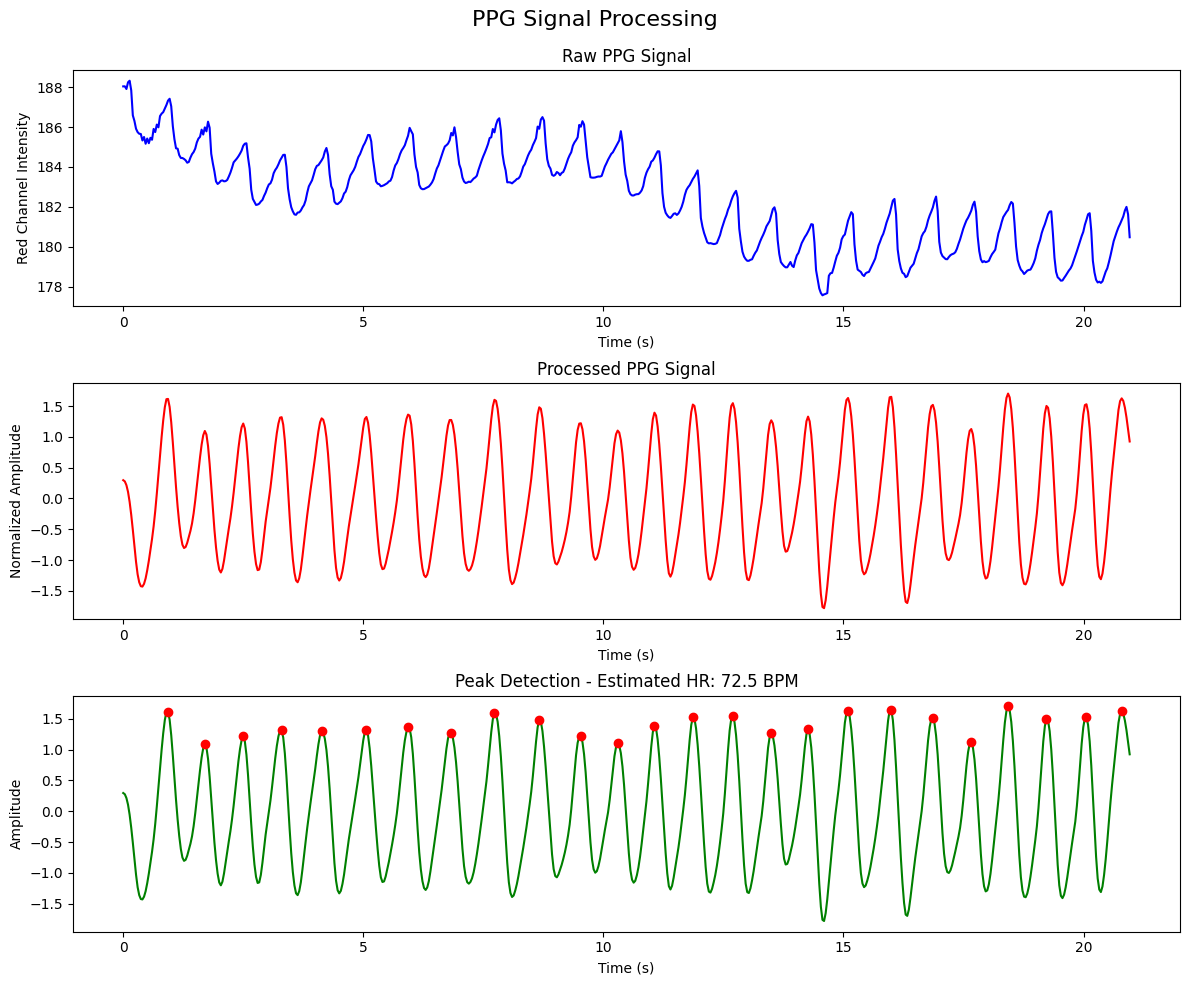

In [106]:
video_path = "PPG_Unseen/PPG_AM_PM20.mp4"
results = process_video_for_glucose_prediction(video_path)

print(f"Signal quality metric: {results['quality_metric']:.4f}")
if 'heart_rate' in results['features']:
    print(f"Estimated heart rate: {results['features']['heart_rate']:.1f} BPM")

plt.show()

In [107]:
def calibrate_with_reference(model, ppg_videos, reference_values):
    """
    Calibrate model predictions using reference values from a glucometer
    
    Parameters:
    model: The prediction model
    ppg_videos (list): List of video paths
    reference_values (list): Corresponding reference glucose values
    
    Returns:
    tuple: (calibration_factor, calibration_offset)
    """
    predictions = []
    
    # Get model predictions for all videos
    for video_path in ppg_videos:
        results = process_video_for_glucose_prediction(video_path, model)
        if results['prediction'] is not None:
            predictions.append(results['prediction'])
        else:
            print(f"Failed to get prediction for {video_path}")
            return 1.0, 0.0
    
    # If we have enough paired data, calculate calibration parameters
    if len(predictions) > 1 and len(predictions) == len(reference_values):
        predictions = np.array(predictions)
        reference_values = np.array(reference_values)
        
        # Find linear relationship (y = ax + b)
        a, b = np.polyfit(predictions, reference_values, 1)
        
        print(f"Calibration factor: {a:.3f}, Offset: {b:.3f}")
        return a, b
    else:
        print("Not enough paired data for calibration")
        return 1.0, 0.0

In [108]:
def batch_process_videos(video_folder, pattern="*.mp4", model=None, 
                        calibration_factor=1.0, calibration_offset=0.0):
    """
    Process all videos in a folder matching the pattern
    
    Parameters:
    video_folder (str): Path to folder containing videos
    pattern (str): Glob pattern to match video files
    model: The prediction model
    calibration_factor (float): Multiplication factor for calibration
    calibration_offset (float): Offset value for calibration
    
    Returns:
    dict: Dictionary with results for each video
    """
    import glob
    import os
    
    # Find all matching videos
    video_paths = glob.glob(os.path.join(video_folder, pattern))
    
    if not video_paths:
        print(f"No videos found matching {pattern} in {video_folder}")
        return {}
    
    results = {}
    
    # Process each video
    for video_path in video_paths:
        video_name = os.path.basename(video_path)
        print(f"Processing {video_name}...")
        
        try:
            # Process video
            video_results = process_video_for_glucose_prediction(
                video_path, model, calibration_factor, calibration_offset
            )
            
            # Store results
            results[video_name] = {
                'quality_metric': video_results['quality_metric'],
                'heart_rate': video_results['features'].get('heart_rate', 0),
                'prediction': video_results['prediction'],
            }
            
            # Save the figure
            if video_results['figure'] is not None:
                figure_path = os.path.join(video_folder, f"{os.path.splitext(video_name)[0]}_analysis.png")
                video_results['figure'].savefig(figure_path)
                plt.close(video_results['figure'])
                
        except Exception as e:
            print(f"Error processing {video_name}: {e}")
            results[video_name] = {'error': str(e)}
    
    # Print summary
    print("\nSummary of results:")
    for video_name, result in results.items():
        if 'error' in result:
            print(f"{video_name}: Error - {result['error']}")
        elif result['prediction'] is not None:
            print(f"{video_name}: Glucose={result['prediction']:.2f} mg/dL, HR={result['heart_rate']:.1f} BPM, Quality={result['quality_metric']:.4f}")
        else:
            print(f"{video_name}: No prediction available, HR={result['heart_rate']:.1f} BPM, Quality={result['quality_metric']:.4f}")
    
    return results

In [109]:
import pickle

def load_ensemble_model(metadata_path):
    """
    Load ensemble model and scaler from metadata pickle file
    
    Parameters:
    metadata_path (str): Path to the metadata file
    
    Returns:
    tuple: (models, scaler_y)
    """
    try:
        with open(metadata_path, 'rb') as file:
            metadata = pickle.load(file)
        
        models = metadata.get('models', [])
        scaler_y = metadata.get('scaler_y', None)
        
        print(f"Loaded {len(models)} ensemble models")
        return models, scaler_y
    except Exception as e:
        print(f"Error loading ensemble model: {e}")
        return [], None

def ensemble_predict(models, X_test):
    """
    Make prediction using ensemble of models
    
    Parameters:
    models (list): List of trained models
    X_test (ndarray): Input data
    
    Returns:
    ndarray: Averaged predictions
    """
    # Ensure correct shape for LSTM
    if X_test.ndim == 2:
        X_test = np.expand_dims(X_test, axis=-1)
    
    # Get predictions from all models
    predictions = np.array([model.predict(X_test) for model in models])
    
    # Average predictions
    final_predictions = np.mean(predictions, axis=0)
    
    return final_predictions.flatten()

In [110]:
def process_video_with_ensemble(video_path, metadata_path='glucose_ensemble/metadata.pkl'):
    """
    Process video and predict glucose using ensemble model
    
    Parameters:
    video_path (str): Path to the video file
    metadata_path (str): Path to the model metadata file
    
    Returns:
    float: Predicted glucose level
    """
    # Extract and process signal
    raw_signal, sampling_rate, quality_metric = extract_ppg_signal(video_path)
    processed_signal = preprocess_ppg_signal(raw_signal, sampling_rate, quality_metric)
    
    # Prepare for prediction
    X_unseen = prepare_for_prediction(processed_signal, target_length=302)
    
    # Load ensemble model
    loaded_models, loaded_scaler_y = load_ensemble_model(metadata_path)
    
    if not loaded_models or loaded_scaler_y is None:
        print("Failed to load ensemble model")
        return None
    
    # Predict glucose level
    y_pred = ensemble_predict(loaded_models, X_unseen)
    
    # Convert predictions back to original glucose scale
    y_pred_original = loaded_scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Print result
    glucose_level = y_pred_original[0]
    print(f"Predicted Blood Glucose Level: {glucose_level:.2f} mg/dL")
    
    # Visualize the signal
    fig = plot_processing_steps(raw_signal, processed_signal, sampling_rate)
    plt.show()
    
    return glucose_level


In [111]:
def batch_process_with_ensemble(video_folder, pattern="*.mp4", metadata_path='glucose_ensemble/metadata.pkl'):
    """
    Process all videos in a folder using ensemble model
    
    Parameters:
    video_folder (str): Path to folder containing videos
    pattern (str): Glob pattern to match video files
    metadata_path (str): Path to the model metadata file
    
    Returns:
    dict: Dictionary with results for each video
    """
    import glob
    import os
    
    # Find all matching videos
    video_paths = glob.glob(os.path.join(video_folder, pattern))
    
    if not video_paths:
        print(f"No videos found matching {pattern} in {video_folder}")
        return {}
    
    # Load ensemble model once
    loaded_models, loaded_scaler_y = load_ensemble_model(metadata_path)
    
    if not loaded_models or loaded_scaler_y is None:
        print("Failed to load ensemble model")
        return {}
    
    results = {}
    
    # Process each video
    for video_path in video_paths:
        video_name = os.path.basename(video_path)
        print(f"\nProcessing {video_name}...")
        
        try:
            # Extract and process signal
            raw_signal, sampling_rate, quality_metric = extract_ppg_signal(video_path)
            processed_signal = preprocess_ppg_signal(raw_signal, sampling_rate, quality_metric)
            
            # Prepare for prediction
            X_unseen = prepare_for_prediction(processed_signal, target_length=302)
            
            # Predict glucose level
            y_pred = ensemble_predict(loaded_models, X_unseen)
            
            # Convert predictions back to original glucose scale
            y_pred_original = loaded_scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            glucose_level = y_pred_original[0]
            
            # Extract features for quality assessment
            features = extract_features(processed_signal, sampling_rate)
            
            # Store results
            results[video_name] = {
                'glucose_level': glucose_level,
                'quality_metric': quality_metric,
                'heart_rate': features.get('heart_rate', 0)
            }
            
            # Save visualization
            fig = plot_processing_steps(raw_signal, processed_signal, sampling_rate)
            figure_path = os.path.join(video_folder, f"{os.path.splitext(video_name)[0]}_analysis.png")
            fig.savefig(figure_path)
            plt.close(fig)
            
            print(f"{video_name}: Glucose={glucose_level:.2f} mg/dL, HR={features.get('heart_rate', 0):.1f} BPM, Quality={quality_metric:.4f}")
            
        except Exception as e:
            print(f"Error processing {video_name}: {e}")
            results[video_name] = {'error': str(e)}
    
    # Print summary
    print("\nSummary of results:")
    for video_name, result in results.items():
        if 'error' in result:
            print(f"{video_name}: Error - {result['error']}")
        else:
            print(f"{video_name}: Glucose={result['glucose_level']:.2f} mg/dL, HR={result['heart_rate']:.1f} BPM, Quality={result['quality_metric']:.4f}")
    
    return results